In [428]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from wordcloud import WordCloud, ImageColorGenerator
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

#### Loading the dataset

In [420]:
click_data = pd.read_csv('click_ad_data.csv')

#### Exploratory Data Analysis

In [421]:
display(click_data.head())

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [425]:
print(f'The Dataset contain {click_data.shape[1]} columns\n', list(click_data.columns), end = '\n\n')
display(click_data.info() )

The Dataset contain 10 columns
 ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country', 'Timestamp', 'Clicked on Ad']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage

None

#### Data dictionary

**Daily Time Spent on Site**: consumer time on site in minutes<br>
**Age**: cutomer age in years<br>
**Area Income**: Avg. Income of geographical area of consumer<br>
**Daily Internet Usage**: Avg. minutes a day consumer is on the internet<br>
**Ad Topic Line**: Headline of the advertisement<br>
**City**: City of consumer<br>
**Male**: Whether or not consumer was male<br>
**Country**: Country of consumer<br>
**Timestamp**: Time at which consumer clicked on Ad or closed window<br>
**Clicked on Ad**: 0 or 1 indicated clicking on Ad<br>

#### splitting the dataset into training and testing sets

In [345]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in split.split(click_data, click_data['Clicked on Ad']):
    ad_train = click_data.loc[train_index]
    ad_test = click_data.loc[test_index]


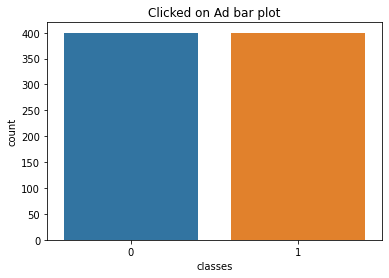

In [346]:
fig, ax = plt.subplots()
target_count = ad_train['Clicked on Ad'].value_counts()
sns.barplot(x=target_count.index, y=target_count,ax=ax)
ax.set_title('Clicked on Ad bar plot');
ax.set_xlabel('classes')
ax.set_ylabel('count');

The target classes are balanced

In [347]:
numerical_columns = ['Daily Time Spent on Site','Age', 'Area Income', 'Daily Internet Usage']
categorical_columns = ['Ad Topic Line','City','Country','Timestamp','Male']

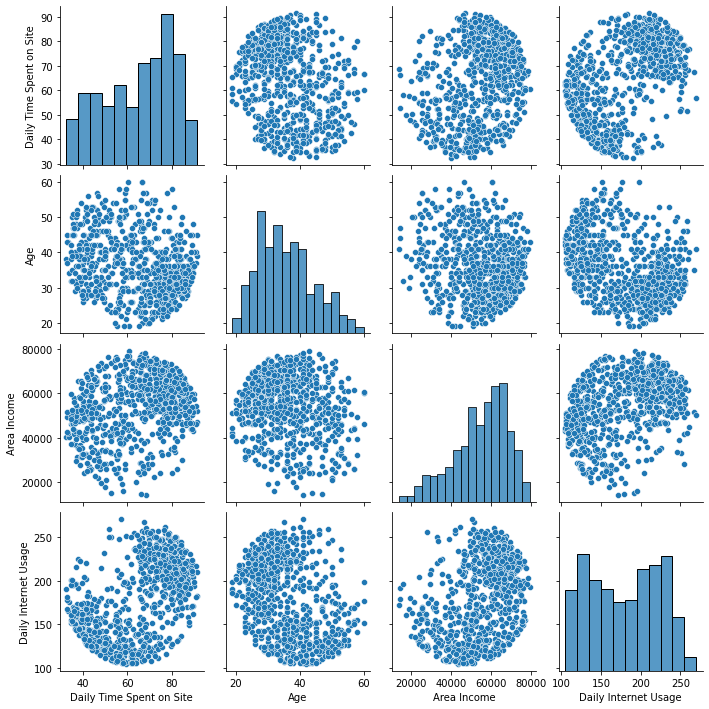

In [348]:
sns.pairplot(ad_train[numerical_columns]);

we notice that there is no correlation between the numerical features<br>
Daily Internet Usage is a bimodel distribution<br>
Area income and Daily Time spent on Site are left skewed<br>
Age is right skewed

In [349]:
ad_train[numerical_columns].describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
count,800.000000,800.00000,800.000000,800.000000
mean,64.954375,35.78875,54922.520538,179.773800
std,15.752824,8.71545,13498.246823,43.974543
min,32.600000,19.00000,13996.500000,104.780000
25%,51.495000,29.00000,47029.292500,138.542500
50%,67.975000,35.00000,57228.185000,182.650000
75%,78.435000,41.00000,65228.125000,218.567500
max,91.430000,60.00000,79332.330000,269.960000


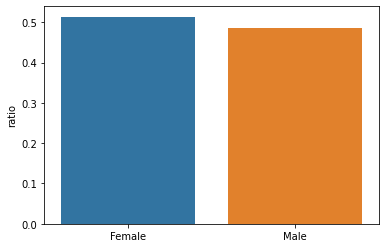

In [350]:
fig, ax = plt.subplots()
male_perc = ad_train['Male'].value_counts()/len(ad_train)
sns.barplot(x=['Female','Male'], y=male_perc,ax=ax)
ax.set_ylabel('ratio');

the ratio of male and female users in the dataset is almost the same

In [351]:
ad_train.groupby(['Male','Clicked on Ad'])['Clicked on Ad'].count().unstack()

Clicked on Ad,0,1
Male,,
0,198,213
1,202,187


The ratio of users who clicked on ads is balanced between males and females

In [352]:
num_cities = ad_train['City'].nunique()
num_countries = ad_train['Country'].nunique()
print('number of distinct cities', num_cities)
print('number of distinct countries',num_countries)

number of distinct cities 778
number of distinct countries 230


In [353]:
timestamp_col_train = ad_train['Timestamp']
timestamp_col_test = ad_test['Timestamp']
date_col = timestamp_col_train.apply(lambda d: d.split()[0])
min_timestamp = date_col.min()
max_timestamp = date_col.max()

print(f'The data timestamp ranges between {min_timestamp} and {max_timestamp}')

The data timestamp ranges between 2016-01-01 and 2016-07-23


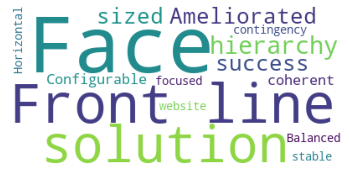

In [433]:
text = ad_train['Ad Topic Line'].str.cat(sep=' ')
wordcloud = WordCloud(max_words=15, background_color="white").generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

the words Face, solution, front, line are the most frequent in Ad Topic Line

#### Feature Engineering

In [354]:
hours_train = timestamp_col_train.apply(lambda d: int(d.split(' ')[1].split(':')[0]))
ad_train.insert(0,'hours',hours_train)
hours_test = timestamp_col_test.apply(lambda d: int(d.split(' ')[1].split(':')[0]))
ad_test.insert(0,'hours',hours_test)

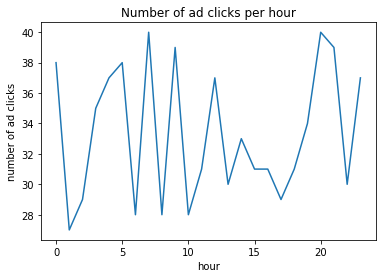

In [355]:
fig, ax = plt.subplots()
h = ad_train.groupby('hours')['Clicked on Ad'].count()
ax.plot(h.index, h)
ax.set_title('Number of ad clicks per hour')
ax.set_xlabel('hour')
ax.set_ylabel('number of ad clicks');

#### Target encoding Country

In [362]:
target_encoder = ce.TargetEncoder(cols=['Country'],handle_unknown='value')
ad_train_enc = target_encoder.fit_transform(ad_train.iloc[:,:-1],ad_train.iloc[:,-1])
ad_train_enc['Clicked on Ad'] = ad_train['Clicked on Ad']

ad_test_enc = target_encoder.transform(ad_test.iloc[:,:-1])
ad_test_enc['Clicked on Ad'] = ad_test['Clicked on Ad']

In [429]:
#base model

cols = ['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Male', 'Country']
label = 'Clicked on Ad'
X = ad_train_enc[cols]
y = ad_train_enc[label]

base = LogisticRegression(random_state=0)
scores = cross_val_score(base, X, y,
                         scoring="recall", cv=5)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.875  0.95   0.8125 0.8875 0.95  ]
Mean: 0.8950000000000001
Standard deviation: 0.051599418601375714


#### scaling the numerical columns

In [365]:
numerical_columns = ['Daily Time Spent on Site','Age', 'Area Income', 'Daily Internet Usage']

sc = StandardScaler()
sc.fit(ad_train_enc[numerical_columns])

ad_train_num = pd.DataFrame(sc.transform(ad_train_enc[numerical_columns]), columns=numerical_columns)
ad_test_num = pd.DataFrame(sc.transform(ad_test_enc[numerical_columns]), columns=numerical_columns)

#### computing tf-idf of Ad Topic Line

In [366]:
train_text = list(ad_train['Ad Topic Line'])
test_text = list(ad_test['Ad Topic Line'])

vectorizer = TfidfVectorizer(min_df=33,stop_words='english')
vectorizer.fit(train_text)
words_tfidf = vectorizer.get_feature_names()

tfidf_train = pd.DataFrame(vectorizer.transform(train_text).toarray(), columns=words_tfidf )
tfidf_test = pd.DataFrame(vectorizer.transform(test_text).toarray(), columns=words_tfidf)

#### Merging the transformed column into one dataframe

In [376]:
ad_train_final = pd.concat([ad_train_num, tfidf_train, ad_train_enc[['hours','Country']].reset_index()], axis=1)
ad_test_final = pd.concat([ad_test_num, tfidf_test, ad_test_enc[['hours','Country']].reset_index()], axis=1)

ad_train_label = ad_train_enc.iloc[:,-1]
ad_test_label = ad_test_enc.iloc[:,-1]

#### models hyper parameters tuning

In [407]:
def grid_search(model, params, X, y):
    
    grid_search = GridSearchCV(model, params, cv=5,
                           scoring='recall')
    grid_search.fit(X, y)
    return grid_search.best_score_, grid_search.best_params_

In [411]:
models = [RandomForestClassifier(), KNeighborsClassifier(),LogisticRegression()]
params_grid = {'random forest':{'n_estimators':[10,50,100,150],'max_depth':[5,15,None]},
              'knn': {'n_neighbors':[2,4,8], 'p':[1,2]},
              'logistic regression': {'penalty':['l1','l2'], 'C':[0.01,0.1,1,10]}}
models_name = list(params_grid)

for model_name, model in zip(models_name, models):
    score_best_model, best_params = grid_search(model, params_grid[model_name],
                                                ad_train_final, ad_train_label)
    print(model_name, best_params,score_best_model, sep = '\n', end='\n\n')

random forest
{'max_depth': 5, 'n_estimators': 50}
0.9724999999999999

knn
{'n_neighbors': 8, 'p': 1}
0.5075000000000001

logistic regression
{'C': 10, 'penalty': 'l2'}
0.975



#### Final model

In [432]:
final_params = {'C': 10, 'penalty': 'l2'}
final_model = LogisticRegression(**final_params)
final_model.fit(ad_train_final, ad_train_label)

pred_test = final_model.predict(ad_test_final)
print('final model recall', recall_score(pred_test, ad_test_label))
print('final model confusion matrix\n',confusion_matrix(pred_test, ad_test_label))

final model recall 0.9591836734693877
final model confusion matrix
 [[96  6]
 [ 4 94]]
